In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.train_val_test import setup_seed
import torch

SEED = setup_seed()

rna_path = "data/rna.csv"
pam50 = "data/pam50_labels.csv"

if not os.path.isfile(rna_path):
    # Create rna file
    metabric_path = "data/METABRIC_CLIN_GE_CNA.csv"
    complete_data = pd.read_csv(metabric_path, index_col=None, header=0, low_memory=False)
    complete_data = complete_data.drop(
        complete_data[complete_data["Pam50Subtype"] == "?"].index
    )

    rna = complete_data.filter(["METABRIC_ID"]+[col for col in complete_data.columns if col.startswith("GE_")])
    rna = rna.set_index("METABRIC_ID")
    rna = (rna-rna.min())/(rna.max()-rna.min())
    
    rna.to_csv(rna_path)
else:
    # Read rna file
    rna = pd.read_csv(rna_path, index_col=0)

pam50_labels = pd.read_csv(pam50, index_col=0)
mask_test = np.genfromtxt("data/mask_test.csv", delimiter=",", dtype=bool)
pam50_labels_train = pam50_labels["Pam50Subtype"][~mask_test]
rna_train = rna[~mask_test]
rna_train.shape

(1579, 1000)

In [101]:
import pandas as pd
import numpy as np

cna_path = "data/cna.csv"

if not os.path.isfile(cna_path):
    metabric_path = "data/METABRIC_CLIN_GE_CNA.csv"
    complete_data = pd.read_csv(metabric_path, index_col=None, header=0, low_memory=False)
    complete_data = complete_data.drop(
        complete_data[complete_data["Pam50Subtype"] == "?"].index
    )

    cna = complete_data.filter(["METABRIC_ID"]+[col for col in complete_data.columns if col.startswith("CNA_")])
    cna = cna.set_index("METABRIC_ID")

    cna = (cna+2)/4
    cna.to_csv(cna_path)
else:
    cna = pd.read_csv(cna_path, index_col=0)
cna_train = cna[~mask_test]
cna_train.shape

(1579, 1000)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class Omics(Dataset):

    def __init__(self, rna):
        """
        Arguments:
            rna: RNA numpy array, masked
        """
        # Filter RNA
        self.omics = torch.tensor(rna.values, dtype=torch.float32)
        self.num_features = self.omics.size()[1]

    def __len__(self):
        return len(self.omics)

    def __getitem__(self, idx):
        return self.omics[idx]

In [79]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Literal

_REGULARISATION = Literal["mmd", "kld"]


class VAE(nn.Module):
    def __init__(
        self,
        layers_dims,
        beta=0.000020,
        activation_fn=nn.Sigmoid(),
        d_p=0,
        loss_fn=nn.MSELoss(reduction="mean"),
        regularisation: _REGULARISATION = "mmd",
    ):
        super().__init__()

        input_dim, dense_dim, latent_dim = layers_dims

        self.activation_fn = activation_fn
        self.loss_fn = loss_fn
        self.beta = beta
        self.regularisation = regularisation
        # Encoder
        self.encoder_dense = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Dropout(p=d_p),
            nn.Linear(input_dim, dense_dim),
            self.activation_fn,
        )

        self.encoder_mean = nn.Linear(dense_dim, latent_dim)
        self.encoder_log_var = nn.Linear(dense_dim, latent_dim)

        self.decoder_dense = nn.Sequential(
            nn.BatchNorm1d(latent_dim),
            nn.Linear(latent_dim, dense_dim),
            self.activation_fn,
        )
        self.decoder_output = nn.Sequential(
            nn.BatchNorm1d(dense_dim),
            nn.Linear(dense_dim, input_dim),
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Xavier uniform model initialisation
        @source https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)

        return mean

    def forward(self, x):
        # Encoder
        
        x = self.encoder_dense(x)

        latent_mean = self.encoder_mean(x)
        latent_log_var = self.encoder_log_var(x)

        z = self.reparameterize(latent_mean, latent_log_var)
        
        reconstructed = self.decoder_dense(z)
        reconstructed = self.decoder_output(reconstructed)

        return reconstructed, latent_mean, latent_log_var, z

    def compute_kernel(self, x, y):
        """
        source @https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
        """
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1)  # (x_size, 1, dim)
        y = y.unsqueeze(0)  # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
        return torch.exp(-kernel_input)  # (x_size, y_size)

    def compute_mmd(self, x, y):
        """
        source @https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
        """
        x_kernel = self.compute_kernel(x, x)
        y_kernel = self.compute_kernel(y, y)
        xy_kernel = self.compute_kernel(x, y)
        mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
        return mmd

    def compute_kld(self, latent_mean, latent_log_var):
        return -0.5 * torch.mean(
            1 + latent_log_var - latent_mean.pow(2) - latent_log_var.exp()
        )

    def forward_pass(self, x):
        reconstructed, latent_mean, latent_log_var, z = self.forward(x)

        reconstruction_loss = self.loss_fn(reconstructed, x)

        match self.regularisation:
            case "mmd":
                regularisation_loss = self.compute_mmd(reconstructed, x)
            case "kld":
                regularisation_loss = self.compute_kld(latent_mean, latent_log_var)
            case _:
                regularisation_loss = 0

        loss = reconstruction_loss + self.beta * regularisation_loss

        return loss, z

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_VAE(model, dataloader, optimizer):
    model.train()
    loss_sum = 0.0

    for batch_idx, x in enumerate(dataloader):
        x = x.to(DEVICE)

        loss, _ = model.forward_pass(x)
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_sum / len(dataloader)


@torch.no_grad()
def validate_VAE(model, dataloader):
    model.eval()
    loss_sum = 0.0

    for batch_idx, x in enumerate(dataloader):
        x = x.to(DEVICE)
        loss, _ = model.forward_pass(x)
        loss_sum += loss.item()

    return loss_sum / len(dataloader)


from sklearn.manifold import TSNE
import seaborn as sns


@torch.no_grad()
def evaluate_VAE(model, x, pam50_labels):
    model.eval()
    x = x.to(DEVICE)
    loss, z = model.forward_pass(x)

    tsne = TSNE(random_state=SEED)
    z_tsne = tsne.fit_transform(z.cpu().numpy())

    print("T-SNE KL Divergence: ", tsne.kl_divergence_)
    sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=pam50_labels)
    plt.show()


@torch.no_grad()
def VAE_save_latent_space(model, x, output_path):
    model.eval()
    x = x.to(DEVICE)
    loss, z = model.forward_pass(x)

    np.savetxt(output_path, z.cpu().numpy(), delimiter=",")

In [19]:
import optuna
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler

N_TRIALS = 1
TIMEOUT = 2 * 60  # in seconds

N_SPLITS = 2
EPOCHS = 50
MAX_LATENT = 256
INPUT_DIM = 1000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_activation_fn(trial, activation_functions=None):
    if not activation_functions:
        activation_functions = {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "elu": nn.ELU(),
            "leakyrelu": nn.LeakyReLU(0.2),
        }

    activation = trial.suggest_categorical(
        "activation", list(activation_functions.keys())
    )
    return activation_functions[activation]


def define_model_VAE(trial, input_dim):
    max_hidden_channels = input_dim
    min_hidden_channels = 1
    max_latent_space = MAX_LATENT

    n_layers = trial.suggest_int("n_layers", 0, 4)
    d_layer = trial.suggest_int("d_layer", 0, 8)
    d_layer = d_layer / 10

    beta = trial.suggest_float("beta", 1e-6, 1, log=True)

    activation_fn = get_activation_fn(trial)

    layers = []
    for i in range(n_layers):
        hidden_channels = trial.suggest_int(
            f"n_units_l{i}",
            min_hidden_channels,
            max_hidden_channels,
        )

        layers.append((max_hidden_channels, hidden_channels))
        max_hidden_channels = hidden_channels

    latet_dim = trial.suggest_int(
        "n_units_latent", 1, min(max_hidden_channels, max_latent_space)
    )
    layers.append((max_hidden_channels, latet_dim))
    return layers, beta, activation_fn, d_layer


def objective(trial):
    bs = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-5, 5e-3, log=True)
    layers, beta, activation_fn, d_layer = define_model_VAE(trial, INPUT_DIM)

    val_loss_sum = 0.0

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=False)
    SPLITS = skf.split(rna_train, pam50_labels_train)

    for i, (train_index, test_index) in enumerate(SPLITS):
        model = VAE(layers, beta, activation_fn, d_layer).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        dateset_train = Omics(rna.iloc[train_index])
        loader_train = DataLoader(dateset_train, batch_size=bs, shuffle=True)

        dataset_val = Omics(rna.iloc[test_index])
        loader_val = DataLoader(dataset_val, batch_size=bs, shuffle=True)

        val_loss_best = float("inf")
        for epoch in range(0, EPOCHS):
            train_loss = train_VAE(model, loader_train, optimizer)
            val_loss = validate_VAE(model, loader_val)

            if val_loss_best > val_loss:
                val_loss_best = val_loss

        val_loss_sum += val_loss_best

        trial.report(val_loss_best, i)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss_sum


study_name = "cnaVAE_cv_study"
storage_path = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage_path,
    sampler=TPESampler(seed=SEED),
    load_if_exists=True,
)
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [
    t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE
]

print("Study statistics: ")
print("\tN finished trials: ", len(study.trials))
print("\tN pruned trials: ", len(pruned_trials))
print("\tN completed trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("\tVal loss: ", trial.value)

print("\tParams: ")
for key, value in trial.params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-05 22:04:54,564] Using an existing study with name 'cnaVAE_cv_study' instead of creating a new one.
[I 2023-12-05 22:05:02,296] Trial 1 finished with value: 0.22412819862365724 and parameters: {'batch_size': 32, 'lr': 4.207988669606632e-05, 'weight_decay': 2.6364803038431647e-05, 'n_layers': 0, 'd_layer': 7, 'beta': 0.004042872735027332, 'activation': 'elu', 'n_units_latent': 55}. Best is trial 1 with value: 0.22412819862365724.


Study statistics: 
	N finished trials:  2
	N pruned trials:  0
	N completed trials:  1
Best trial:
	Val loss:  0.22412819862365724
	Params: 
		batch_size: 32
		lr: 4.207988669606632e-05
		weight_decay: 2.6364803038431647e-05
		n_layers: 0
		d_layer: 7
		beta: 0.004042872735027332
		activation: elu
		n_units_latent: 55


In [108]:
import time
from torch_geometric.logging import log
from utils.train_val_test import Early_Stopping
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 150

P_DROPOUT = 0.2
LR = 0.001
BATCH_SIZE = 64
ACTIVATION_FN = nn.ELU()
BETA = 50
LAYERS = [1000,256,64]
# LOSS_FN = nn.MSELoss(reduction="mean")
LOSS_FN = nn.BCEWithLogitsLoss()

model = VAE(LAYERS, BETA, ACTIVATION_FN, P_DROPOUT, LOSS_FN, regularisation="mmd").to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

early_stopping = Early_Stopping(10, mode="minimize")

dateset_train = Omics(cna_train)
loader_train = DataLoader(dateset_train, batch_size=BATCH_SIZE, shuffle=False)

dataset_val = Omics(cna.iloc[mask_test])
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)


for epoch in range(0, EPOCHS):
    start = time.time()
    train_loss = train_VAE(model, loader_train, optimizer)
    val_loss = validate_VAE(model, loader_val)
    
    if epoch % 10 == 0:
        log(
            Epoch=epoch,
            Time=(time.time() - start),
            Train=train_loss,
            Val=val_loss,
        )

    if early_stopping.check(val_loss, model):
        print(f"Early stopped at epoch: {epoch}, Best Val: {early_stopping.best_loss:.4f}")
        model = early_stopping.best_model
        # torch.save(model.state_dict(), "rnaVAE.pth")
        break

Epoch: 000, Time: 0.1657, Train: 0.7132, Val: 0.6716
Epoch: 010, Time: 0.1558, Train: 0.6311, Val: 0.6264
Epoch: 020, Time: 0.1547, Train: 0.6270, Val: 0.6229
Epoch: 030, Time: 0.1562, Train: 0.6262, Val: 0.6221
Epoch: 040, Time: 0.1544, Train: 0.6245, Val: 0.6208
Epoch: 050, Time: 0.1528, Train: 0.6238, Val: 0.6207
Epoch: 060, Time: 0.1560, Train: 0.6234, Val: 0.6208
Epoch: 070, Time: 0.1539, Train: 0.6230, Val: 0.6207
Early stopped at epoch: 72, Best Val: 0.6206


T-SNE KL Divergence:  1.5639920234680176


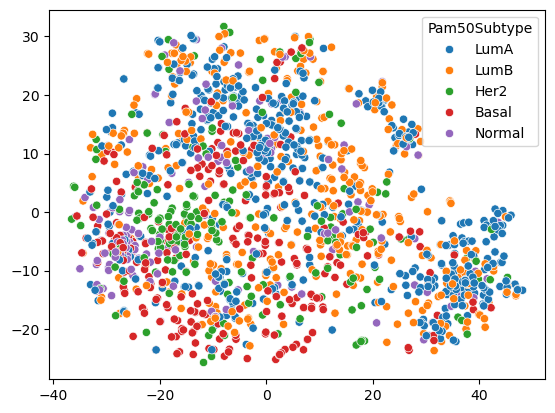

In [109]:
# evaluate_VAE(model, Omics(rna.iloc[mask_test]).omics, pam50_labels[mask_test])
# VAE_save_latent_space(model, Omics(rna).omics, "output/rnaVAE.csv")


latent = None
with torch.no_grad():
    model.eval()
    for batch_idx, x in enumerate(loader_train):
        x = x.to(DEVICE)
        _, z = model.forward_pass(x)
        if latent is not None:
            latent = torch.cat((latent, z), 0)
        else:
            latent = z

tsne = TSNE(random_state=SEED)
z_tsne = tsne.fit_transform(latent.cpu().numpy())

print("T-SNE KL Divergence: ", tsne.kl_divergence_)
sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=pam50_labels_train)
plt.show()
